# Projet complet : XML médical → Entrepôt de données

## Étape 0 : Préparer l’environnement

In [1]:
pip install pandas lxml tqdm sqlalchemy pymysql

Note: you may need to restart the kernel to use updated packages.


## Étape 1 : Lecture et nettoyage des XML
### 1.1 Fonctions utilitaires

In [2]:
import os
import re
import pandas as pd
from lxml import etree
from tqdm import tqdm

# Nettoyer le texte XML
def clean_xml_text(text):
    # Remplacer & non valide
    text = re.sub(r'&(?!amp;|lt;|gt;|quot;|apos;)', '&amp;', text)
    # Supprimer caractères de contrôle
    text = re.sub(r'[\x00-\x08\x0b\x0c\x0e-\x1f]', '', text)
    # Supprimer caractères non imprimables
    text = re.sub(r'[^\x09\x0A\x0D\x20-\x7E\x80-\xFF]', '', text)
    # Supprimer les sauts de ligne entre balises
    text = re.sub(r'>\s+<', '><', text)
    return text

# Parser XML en toute sécurité
def parse_xml_safe(xml_content):
    parser = etree.XMLParser(recover=True)
    return etree.fromstring(xml_content.encode("utf-8"), parser=parser)

# Lecture avec gestion de l'encodage
def read_file_safe(path):
    try:
        with open(path, "r", encoding="utf-8") as f:
            return f.read()
    except UnicodeDecodeError:
        with open(path, "r", encoding="latin-1") as f:
            return f.read()

# Corriger l'encodage (ex: Ã© -> é)
def fix_encoding(text):
    if isinstance(text, str):
        try:
            return text.encode('latin1').decode('utf-8')
        except:
            return text
    return text

# Supprimer retours à la ligne et espaces multiples
def fix_linebreaks(text):
    if isinstance(text, str):
        text = text.replace('\n', ' ')
        text = ' '.join(text.split())
    return text

# Nettoyage complet d'un texte
def clean_text(text):
    text = fix_encoding(text)
    text = fix_linebreaks(text)
    return text


### 1.2 Lecture de tous les fichiers XML et extraction des balises

In [3]:
# Dossier contenant les XML
folder = r"C:\Users\bough\OneDrive\Bureau\TP_archi_moder\casimage_FR"

# Détecter tous les fichiers XML
files = [f for f in os.listdir(folder) if f.lower().endswith(".xml")]

# Détecter toutes les balises présentes dans les fichiers
all_tags = set()
for file in tqdm(files, desc="Détection des balises"):
    path = os.path.join(folder, file)
    content = read_file_safe(path)
    content = clean_xml_text(content)
    try:
        root = parse_xml_safe(content)
        for elem in root.iter():
            all_tags.add(elem.tag)
    except:
        continue

all_tags = sorted(list(all_tags))
print(f"Balises détectées : {all_tags}")


Détection des balises: 100%|███████████████████████████████████████████████████████| 1691/1691 [00:18<00:00, 92.73it/s]

Balises détectées : ['ACR', 'ANSWERA', 'ANSWERB', 'ANSWERC', 'ANSWERD', 'Age', 'Anatomy', 'Author', 'Birthdate', 'CASIMAGE_CASE', 'COMMENTARY', 'CaseID', 'Chapter', 'ClinicalPresentation', 'Commentary', 'Creation', 'DESCRIPTION', 'Date', 'DateTime', 'Department', 'Description', 'Diagnosis', 'Hospital', 'ID', 'ImageThumbnaillID', 'KeyWords', 'LINK', 'Language', 'ODislocation', 'OGraft', 'OImplant', 'OJoint', 'OLocation', 'OOpen', 'OOperation', 'OPathologic', 'OPolytrauma', 'Order', 'QCM', 'QUESTION', 'References', 'Reviewer', 'Sex', 'State', 'Title', 'URL', 'WEBLINK', 'WEBURL']


Interprétation : On récupère toutes les balises uniques de tous les XML. Cela permet de construire automatiquement les colonnes du CSV.

### 1.3 Extraction des données dans un DataFrame

In [4]:
data_rows = []
for file in tqdm(files, desc="Extraction des données"):
    path = os.path.join(folder, file)
    content = read_file_safe(path)
    content = clean_xml_text(content)
    try:
        root = parse_xml_safe(content)
        row = {tag: "" for tag in all_tags}
        for elem in root.iter():
            if elem.text:
                row[elem.tag] = clean_text(elem.text)
        data_rows.append(row)
    except:
        print(f" Fichier corrompu : {file}")

df = pd.DataFrame(data_rows)
df.to_csv("casimage_brut.csv", index=False, encoding="utf-8-sig")
print(f" CSV brut généré avec {len(df)} lignes")


Extraction des données: 100%|████████████████████████████████████████████████████| 1691/1691 [00:00<00:00, 1950.10it/s]


 CSV brut généré avec 1691 lignes


Interprétation : Chaque fichier XML devient une ligne dans le CSV, chaque balise une colonne.

## Étape 2 : Nettoyage des données CSV

### 2.1 Supprimer colonnes inutiles

In [5]:
colonnes_a_supprimer = [
    'CASIMAGE_CASE', 'LINK', 'QCM', 'Sex', 'WEBLINK',
    'DESCRIPTION', 'OImplant', 'OJoint', 'OLocation'
]
df_clean = df.drop(columns=[col for col in colonnes_a_supprimer if col in df.columns])


### 2.2 Gérer valeurs manquantes

In [6]:
# Remplacer NaN par "Non spécifié"
df_clean.fillna("Non spécifié", inplace=True)

### 2.3 Nettoyage texte et normalisation

In [7]:
colonnes_texte = ['Description', 'ClinicalPresentation', 'Commentary']

for col in colonnes_texte:
    if col in df_clean.columns:
        df_clean[col] = df_clean[col].apply(clean_text)

# Normaliser le sexe si présent
if 'Sex' in df_clean.columns:
    df_clean['Sex'] = df_clean['Sex'].apply(lambda x: 'Homme' if str(x).lower() in ['m','male','homme'] else ('Femme' if str(x).lower() in ['f','female','femme'] else 'Non spécifié'))


### 2.4 Nettoyage des dates

In [8]:
if 'Date' in df_clean.columns:
    df_clean['Date'] = pd.to_datetime(df_clean['Date'], errors='coerce')


C:\Users\bough\AppData\Local\Temp\ipykernel_17236\3134304755.py:2: UserWarning: Parsing dates in %d.%m.%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df_clean['Date'] = pd.to_datetime(df_clean['Date'], errors='coerce')


### 2.5 Supprimer doublons

In [9]:
df_clean.drop_duplicates(inplace=True)
df_clean.to_csv("casimage_nettoye.csv", index=False, encoding="utf-8-sig")
print(" CSV nettoyé généré")


 CSV nettoyé généré


In [10]:
pip install matplotlib seaborn plotly missingno

Note: you may need to restart the kernel to use updated packages.


In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
import plotly.express as px

# Affichage inline pour Jupyter Notebook
%matplotlib inline

In [12]:
df = pd.read_csv("casimage_nettoye.csv")
print(df.shape)
df.head()

(1691, 39)


,ACR,ANSWERA,ANSWERB,ANSWERC,ANSWERD,Age,Anatomy,Author,Birthdate,COMMENTARY,...,OPathologic,OPolytrauma,Order,QUESTION,References,Reviewer,State,Title,URL,WEBURL
0,NaN,FSP-6,FSP-4,FSP-5,FSP-7,44,NaN,BERIS Photis,18.08.2003,NaN,...,0,0,0,Le lymphocyte stimulé se trouve sur l'image :,NaN,NaN,NaN,Hématologie-APP-2ème,NaN,http://129.195.254.38:5000/4DMETHOD/_HTML_MCas...
1,NaN,NaN,NaN,NaN,NaN,0,NaN,BERIS Photis,18.08.2003,NaN,...,0,0,0,NaN,NaN,NaN,NaN,Hématologie-APP-2ème,NaN,http://129.195.254.38:5000/4DMETHOD/_HTML_MCas...
2,NaN,NaN,NaN,NaN,NaN,0,NaN,BERIS Photis,18.08.2003,NaN,...,0,0,0,NaN,NaN,NaN,NaN,Hématologie-APP-2ème,NaN,http://129.195.254.38:5000/4DMETHOD/_HTML_MCas...
3,NaN,NaN,NaN,NaN,NaN,77,NaN,BERIS Photis,18.08.2003,NaN,...,0,0,0,NaN,NaN,NaN,NaN,Hématologie-APP-3ème,NaN,http://129.195.254.38:5000/4DMETHOD/_HTML_MCas...
4,NaN,NaN,NaN,NaN,NaN,40,NaN,BERIS Photis,18.08.2003,NaN,...,0,0,0,NaN,NaN,NaN,NaN,Hématologie-APP-3ème,NaN,http://129.195.254.38:5000/4DMETHOD/_HTML_MCas...


In [13]:
#Visualisation des valeurs manquantes

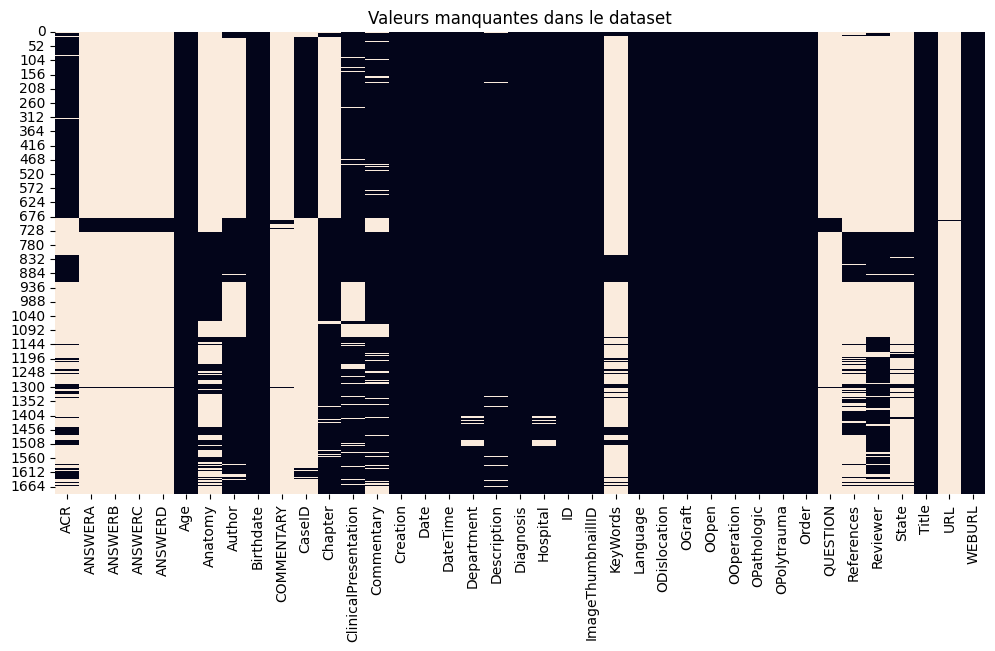

<Axes: >

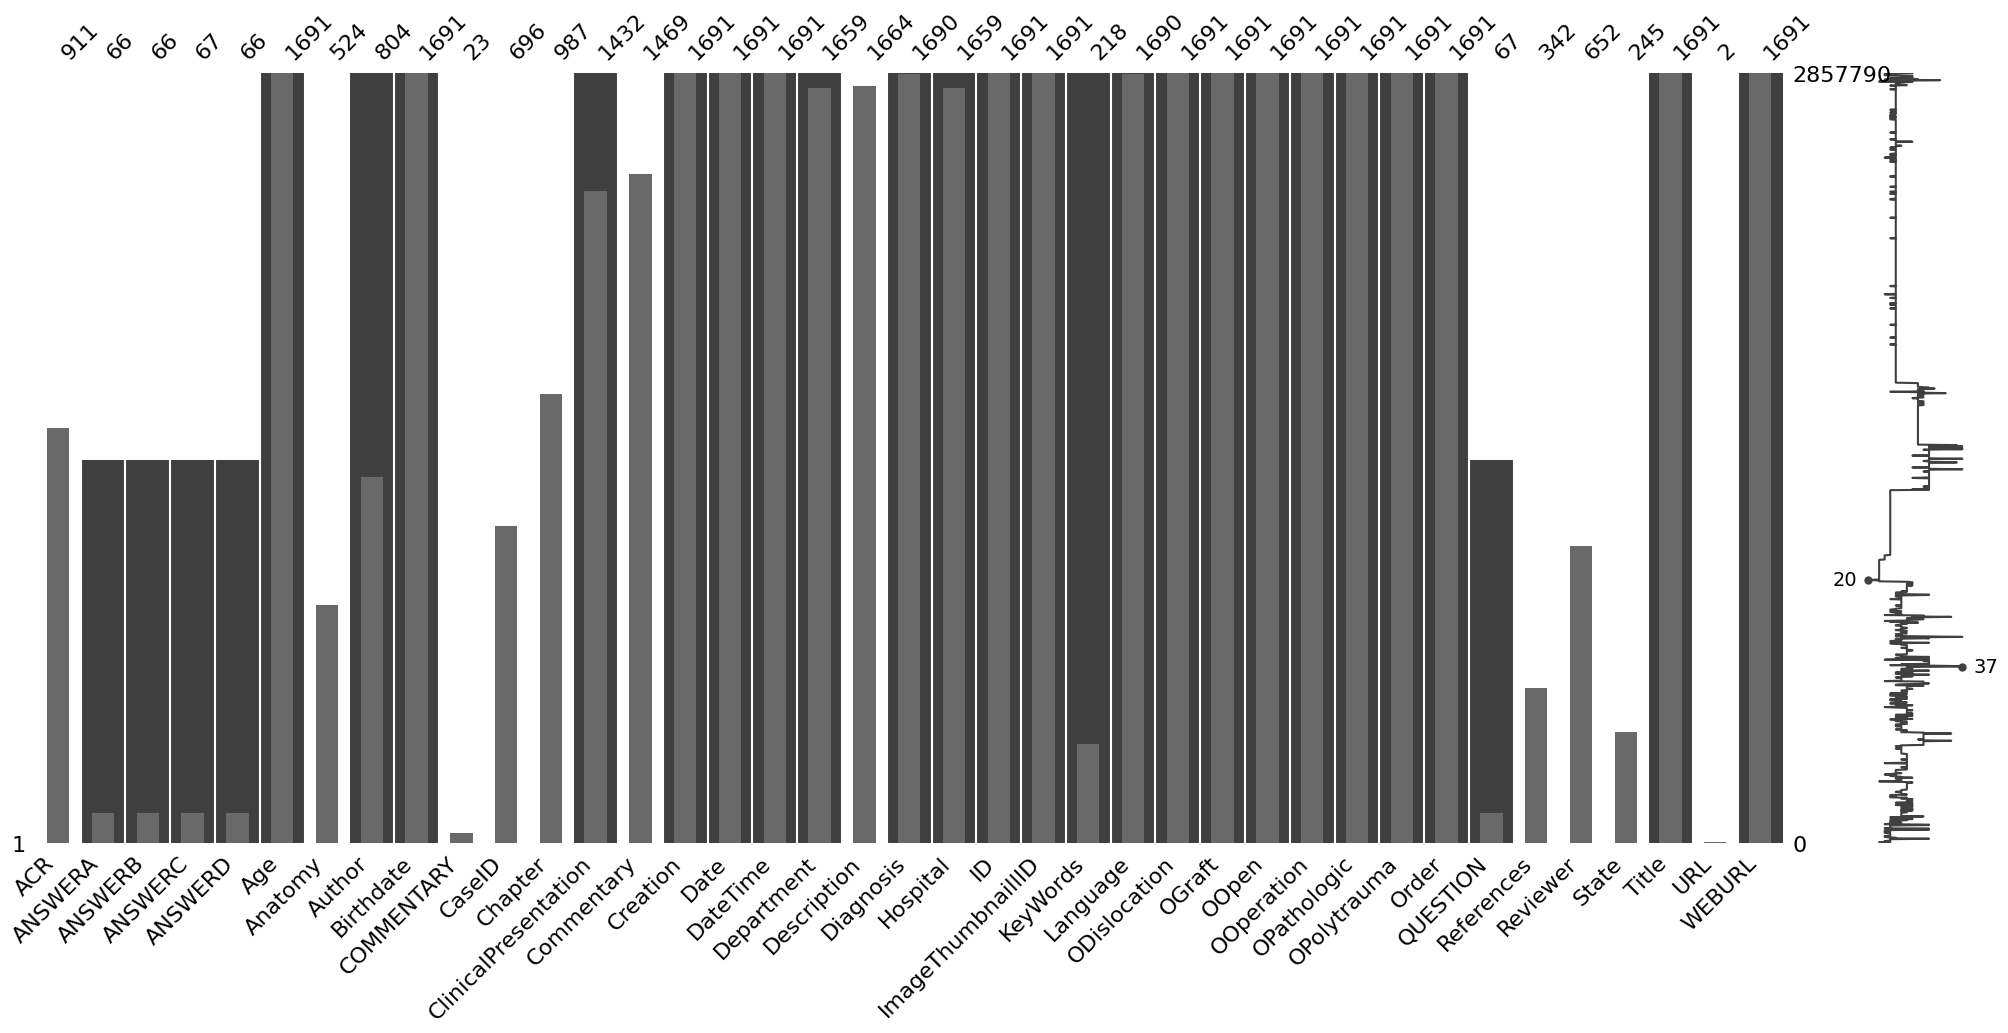

In [14]:
# Heatmap des valeurs manquantes
plt.figure(figsize=(12,6))
sns.heatmap(df.isnull(), cbar=False)
plt.title("Valeurs manquantes dans le dataset")
plt.show()

# Diagramme interactif missingno
msno.matrix(df)
msno.bar(df)


Interprétation :
On voit rapidement quelles colonnes ont beaucoup de données manquantes (ex: ANSWER*, KeyWords, OImplant). Cela permet de décider quoi supprimer ou garder.

In [15]:
#Distribution des colonnes numériques

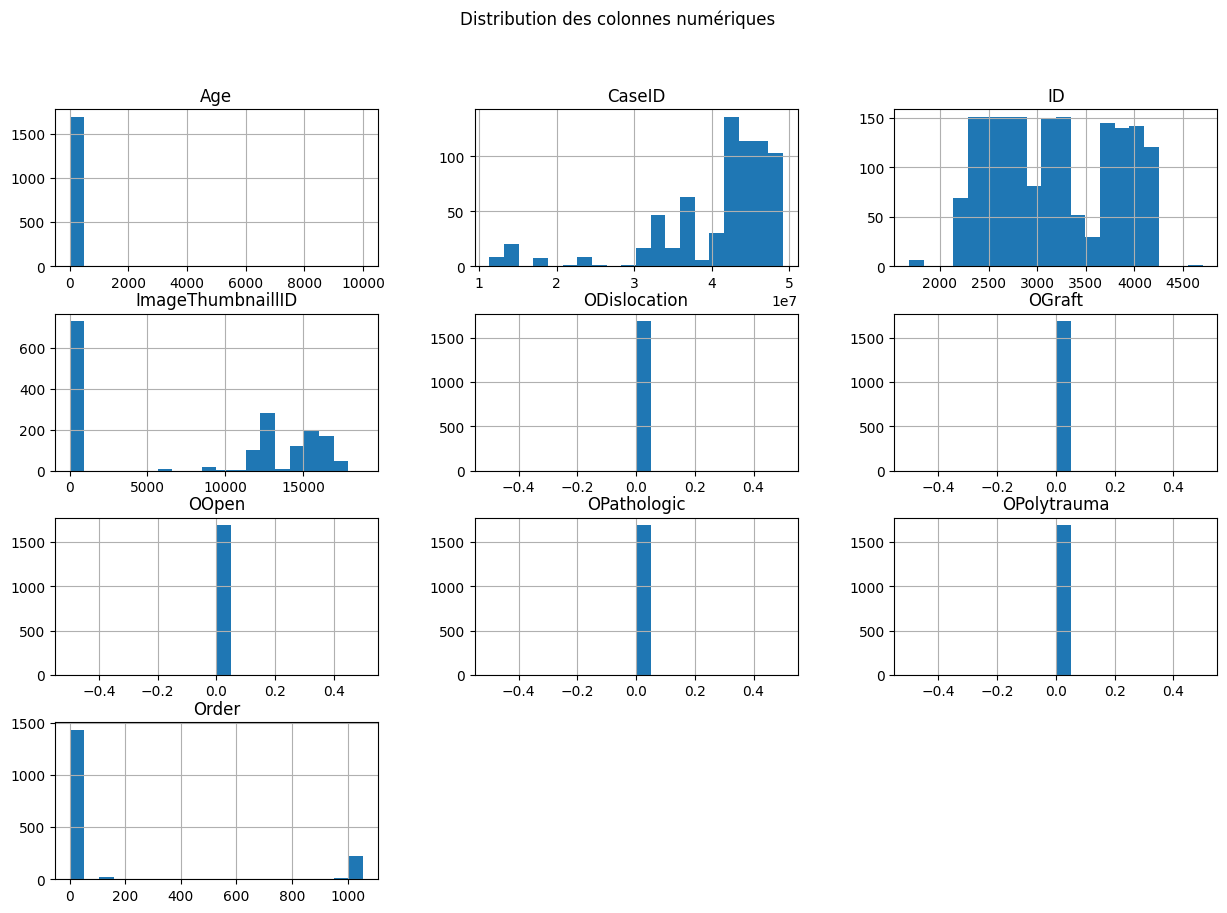

In [16]:
numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns
df[numerical_cols].hist(figsize=(15,10), bins=20)
plt.suptitle("Distribution des colonnes numériques")
plt.show()

In [17]:
#Histogramme ou countplot des colonnes catégorielles

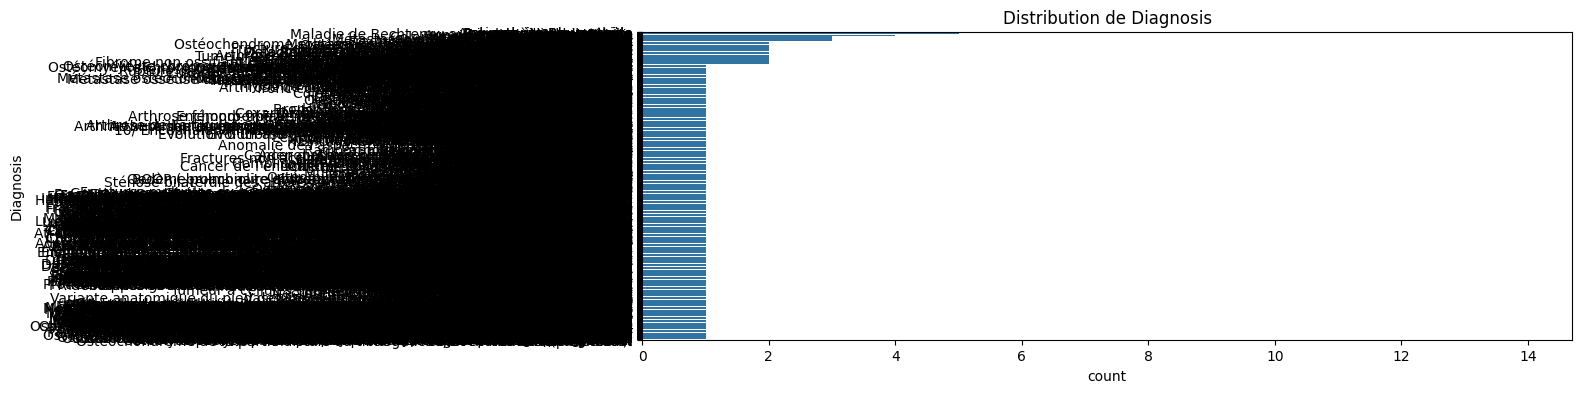

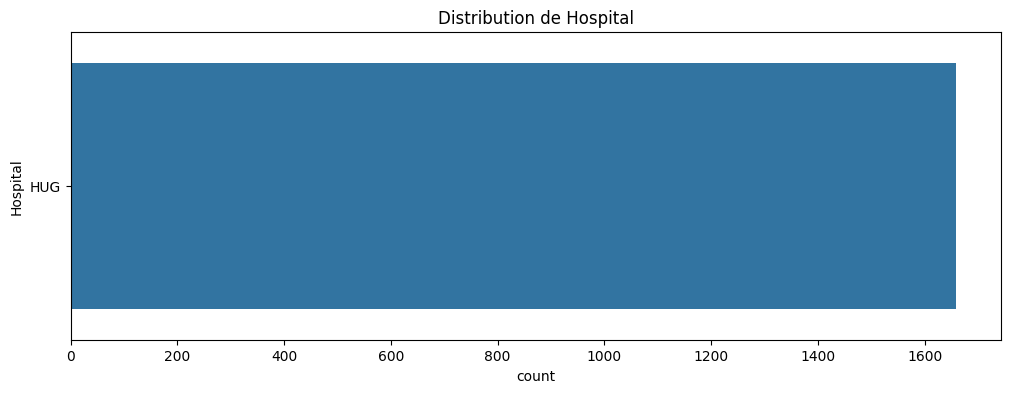

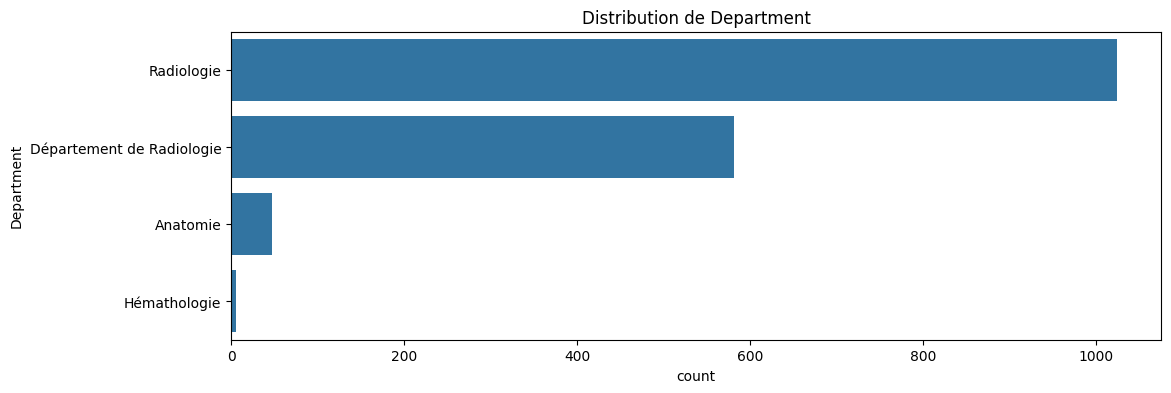

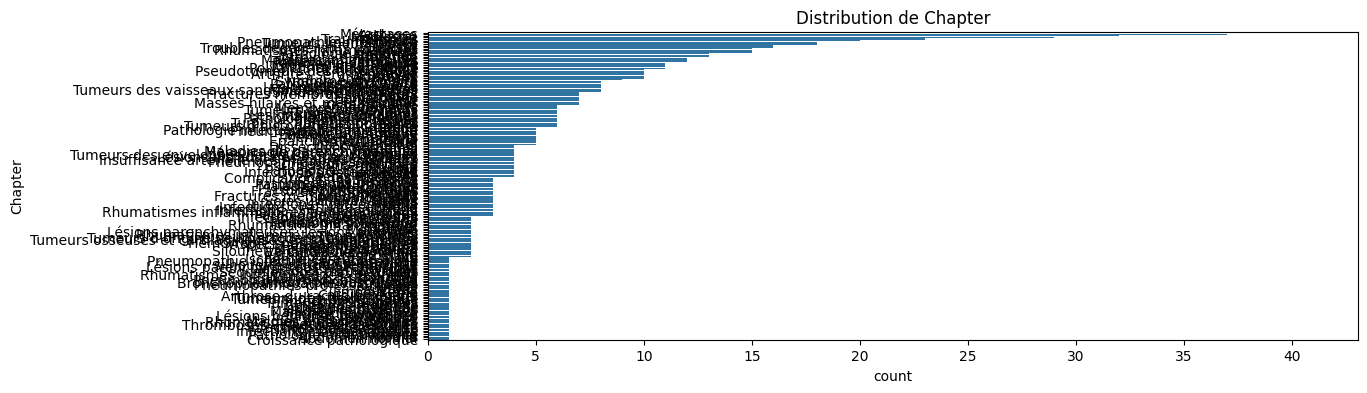

In [18]:
categorical_cols = ['Diagnosis', 'Hospital', 'Department', 'Sex', 'Chapter']

for col in categorical_cols:
    if col in df.columns:
        plt.figure(figsize=(12,4))
        sns.countplot(data=df, y=col, order=df[col].value_counts().index)
        plt.title(f"Distribution de {col}")
        plt.show()


Interprétation :
On voit quelles catégories sont les plus fréquentes, par ex quels hôpitaux ou diagnostics sont les plus représentés.

In [19]:
#Boxplots pour détecter les valeurs extrêmes

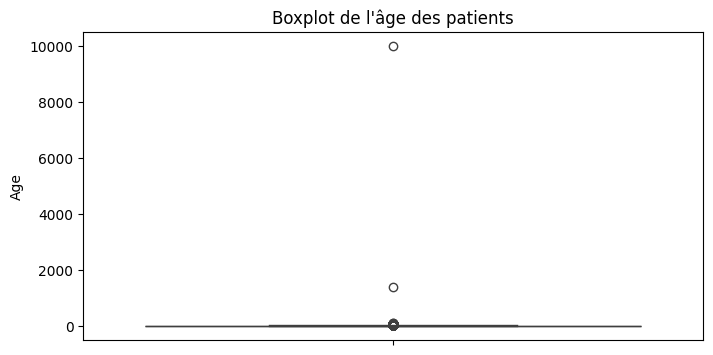

In [20]:
# Exemple sur Age
if 'Age' in df.columns:
    plt.figure(figsize=(8,4))
    sns.boxplot(df['Age'])
    plt.title("Boxplot de l'âge des patients")
    plt.show()


Interprétation : On peut détecter des valeurs aberrantes dans les âges ou autres colonnes numériques.

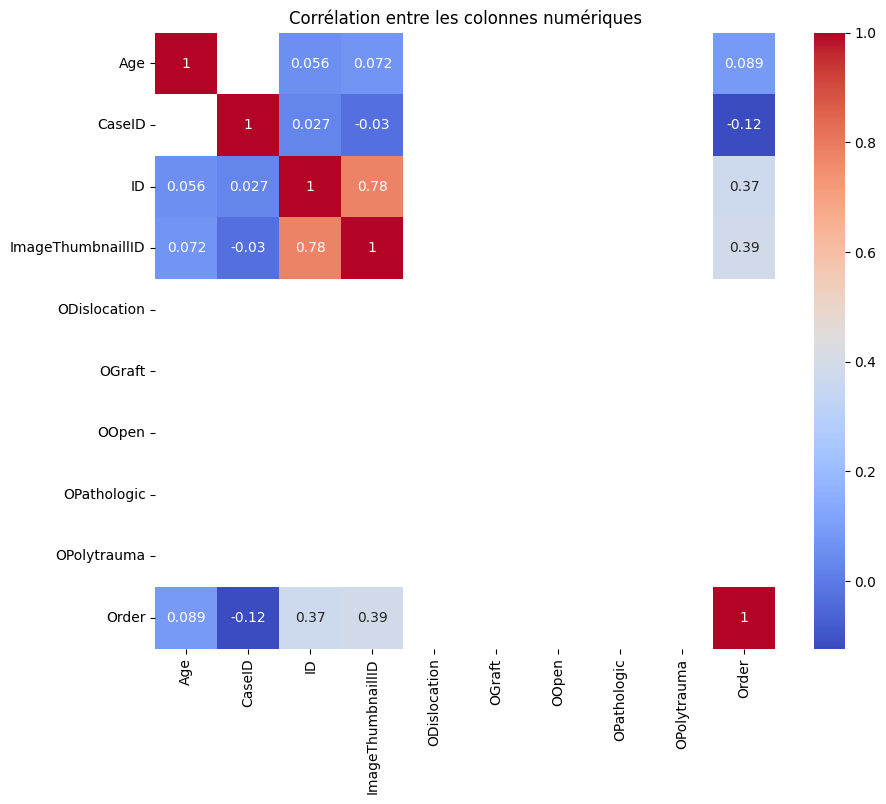

In [21]:
#Corrélations entre colonnes numériques
plt.figure(figsize=(10,8))
sns.heatmap(df[numerical_cols].corr(), annot=True, cmap='coolwarm')
plt.title("Corrélation entre les colonnes numériques")
plt.show()

Interprétation : utile si certaines mesures sont liées (ex: OPolytrauma vs OPathologic).

In [22]:
#Visualisations interactives avec Plotly
# Histogramme interactif
if 'Age' in df.columns:
    fig = px.histogram(df, x='Age', nbins=30, title="Distribution interactive des âges")
    fig.show()

# Bar chart interactif pour les diagnostics
if 'Diagnosis' in df.columns:
    top_diag = df['Diagnosis'].value_counts().nlargest(20)
    fig = px.bar(x=top_diag.index, y=top_diag.values, title="Top 20 Diagnostics")
    fig.show()


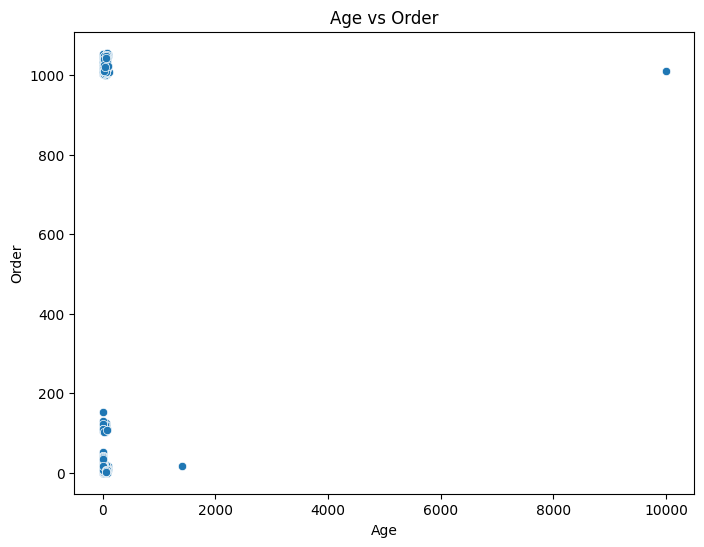

In [23]:
#Nuages de points / scatter plots
# Exemple Age vs Order (si pertinent)
if 'Age' in df.columns and 'Order' in df.columns:
    plt.figure(figsize=(8,6))
    sns.scatterplot(x='Age', y='Order', data=df)
    plt.title("Age vs Order")
    plt.show()


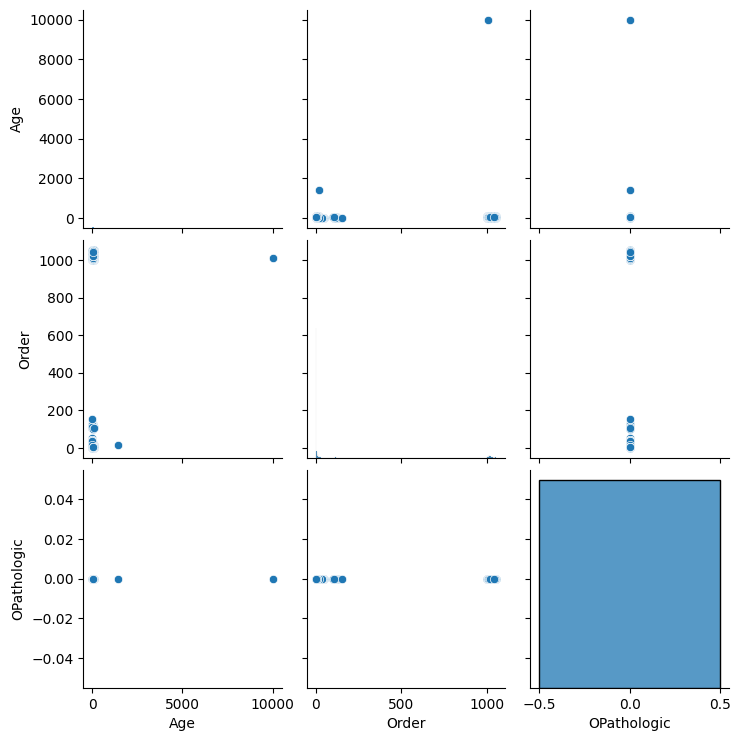

In [24]:
#Shapley / distributions multivariées
# Pairplot pour quelques colonnes numériques
sample_cols = ['Age','Order','OPathologic','OOperation']
sns.pairplot(df[sample_cols])
plt.show()


Interprétation :
Permet d’analyser les relations entre plusieurs mesures, très utile avant de créer le modèle multidimensionnel.

## Étape 3 : Création des dimensions et table de faits
### 3.1 : Identifier les dimensions et la table de faits

on peut définir les dimensions et faits comme suit :

**Dimensions**

***Patient : informations personnelles***

PatientID ou ID

Age

Birthdate

***Diagnosis (diagnostic) :***

Diagnosis

***Hospital :***

Hospital

***Department***

***Date :***

Date (ou Creation ou DateTime)

***Cas / Intervention :***

ID ou CaseID

***Type d’opération (OOperation)***

**Table de faits**

Contient les mesures liées au cas :

***ID_Case***

***FK vers chaque dimension : ID_Patient, ID_Diagnosis, ID_Hospital, ID_Date***

***Mesures supplémentaires si disponibles : OPathologic, OPolytrauma, OOpen***

Interprétation :
Les dimensions décrivent le contexte (qui, où, quand, quoi), la table de faits contient les mesures quantitatives ou événements liés à ces dimensions.

### 3.2 : Création des IDs uniques pour chaque dimension

In [25]:
import pandas as pd

# Charger le CSV nettoyé
df = pd.read_csv("casimage_nettoye.csv")

# Générer un ID unique pour chaque Patient
df['ID_Patient'] = pd.factorize(df['ID'])[0] + 1  # ID unique à chaque patient

# ID pour Diagnosis
df['ID_Diagnosis'] = pd.factorize(df['Diagnosis'])[0] + 1

# ID pour Hospital
df['ID_Hospital'] = pd.factorize(df['Hospital'])[0] + 1

# ID pour Date
df['ID_Date'] = pd.factorize(df['Date'])[0] + 1

# ID pour Case
df['ID_Case'] = pd.factorize(df['ID'])[0] + 1

df.head(5)


,ACR,ANSWERA,ANSWERB,ANSWERC,ANSWERD,Age,Anatomy,Author,Birthdate,COMMENTARY,...,Reviewer,State,Title,URL,WEBURL,ID_Patient,ID_Diagnosis,ID_Hospital,ID_Date,ID_Case
0,NaN,FSP-6,FSP-4,FSP-5,FSP-7,44,NaN,BERIS Photis,18.08.2003,NaN,...,NaN,NaN,Hématologie-APP-2ème,NaN,http://129.195.254.38:5000/4DMETHOD/_HTML_MCas...,1,1,1,1,1
1,NaN,NaN,NaN,NaN,NaN,0,NaN,BERIS Photis,18.08.2003,NaN,...,NaN,NaN,Hématologie-APP-2ème,NaN,http://129.195.254.38:5000/4DMETHOD/_HTML_MCas...,2,2,1,1,2
2,NaN,NaN,NaN,NaN,NaN,0,NaN,BERIS Photis,18.08.2003,NaN,...,NaN,NaN,Hématologie-APP-2ème,NaN,http://129.195.254.38:5000/4DMETHOD/_HTML_MCas...,3,3,1,1,3
3,NaN,NaN,NaN,NaN,NaN,77,NaN,BERIS Photis,18.08.2003,NaN,...,NaN,NaN,Hématologie-APP-3ème,NaN,http://129.195.254.38:5000/4DMETHOD/_HTML_MCas...,4,4,1,1,4
4,NaN,NaN,NaN,NaN,NaN,40,NaN,BERIS Photis,18.08.2003,NaN,...,NaN,NaN,Hématologie-APP-3ème,NaN,http://129.195.254.38:5000/4DMETHOD/_HTML_MCas...,5,5,1,1,5


interprétation 

Chaque dimension a maintenant un identifiant unique. Cela facilitera les relations dans l’entrepôt.

### 3.3 : Créer les tables de dimensions
**3.3.1 : Dimension Patient**

In [26]:
dim_patient = df[['ID_Patient', 'ID', 'Age', 'Birthdate']].drop_duplicates()
dim_patient.rename(columns={'ID':'PatientID'}, inplace=True)
dim_patient.to_csv("DimensionPatient.csv", index=False, encoding="utf-8-sig")
dim_patient.head()

,ID_Patient,PatientID,Age,Birthdate
0,1,1683,44,18.08.2003
1,2,1684,0,18.08.2003
2,3,1685,0,18.08.2003
3,4,1686,77,18.08.2003
4,5,1687,40,18.08.2003


ID_Patient : clé primaire


PatientID : identifiant original


Age et Birthdate : attributs du patient


Interprétation : Table descriptive des patients, chaque patient apparaît une seule fois.

**3.3.2 : Dimension Diagnosis**

In [27]:
dim_diag = df[['ID_Diagnosis', 'Diagnosis']].drop_duplicates()
dim_diag.to_csv("DimensionDiagnosis.csv", index=False, encoding="utf-8-sig")
dim_diag.head()


,ID_Diagnosis,Diagnosis
0,1,Frottis sanguin périphérique normal (leucocytes)
1,2,Hématocrite
2,3,Numération des réticulocytes
3,4,Hématopoïèse normale - médullogramme
4,5,Myélome multiple


Interprétation : Table des diagnostics avec clé unique ID_Diagnosis.

**3.3.3 : Dimension Hospital**

In [28]:
dim_hosp = df[['ID_Hospital', 'Hospital', 'Department']].drop_duplicates()
dim_hosp.to_csv("DimensionHospital.csv", index=False, encoding="utf-8-sig")
dim_hosp.head()

,ID_Hospital,Hospital,Department
0,1,HUG,Hémathologie
6,1,HUG,Département de Radiologie
20,1,HUG,Radiologie
1069,1,HUG,Anatomie
1408,0,NaN,NaN


Interprétation : Table descriptive des hôpitaux et départements.

**3.3.4 : Dimension Date**

In [29]:
dim_date = df[['ID_Date','Date']].drop_duplicates()
dim_date['Date'] = pd.to_datetime(dim_date['Date'], errors='coerce')
dim_date.to_csv("DimensionDate.csv", index=False, encoding="utf-8-sig")
dim_date.head()

,ID_Date,Date
0,1,2003-03-21
1137,2,2003-03-31
1207,3,2003-04-04
1236,4,2003-03-27
1251,5,2003-04-02


Interprétation : Table des dates pour analyses temporelles (ex : tendances par mois ou année).

### 3.4 : Créer la table de faits

La table de faits contient toutes les références aux dimensions + mesures importantes.

In [30]:
fact_cols = [
    'ID_Case', 'ID_Patient', 'ID_Diagnosis', 'ID_Hospital', 'ID_Date',
    'OOperation', 'OOpen', 'OPathologic', 'OPolytrauma', 'Order'
]

fact_table = df[fact_cols]
fact_table.to_csv("FactPatientCase.csv", index=False, encoding="utf-8-sig")
fact_table.head()


,ID_Case,ID_Patient,ID_Diagnosis,ID_Hospital,ID_Date,OOperation,OOpen,OPathologic,OPolytrauma,Order
0,1,1,1,1,1,00.00.00,0,0,0,0
1,2,2,2,1,1,00.00.00,0,0,0,0
2,3,3,3,1,1,00.00.00,0,0,0,0
3,4,4,4,1,1,00.00.00,0,0,0,0
4,5,5,5,1,1,00.00.00,0,0,0,0


Interprétation :
Chaque ligne de FactPatientCase correspond à un cas unique avec des mesures et références vers toutes les dimensions.

### 3.5 : Vérification des dimensions et faits

In [31]:
print("Nombre de patients :", dim_patient.shape[0])
print("Nombre de diagnostics :", dim_diag.shape[0])
print("Nombre d'hôpitaux :", dim_hosp.shape[0])
print("Nombre de dates :", dim_date.shape[0])
print("Nombre de faits :", fact_table.shape[0])

Nombre de patients : 1691
Nombre de diagnostics : 1448
Nombre d'hôpitaux : 5
Nombre de dates : 10
Nombre de faits : 1691


Interprétation :
    

    dim_patient, dim_diag, dim_hosp, dim_date : dimensions uniques
    

    fact_table : toutes les transactions / cas

    
    Cela garantit l’intégrité référentielle avant import dans SQL.

### 3.6 :Ajouter des mesures agrégées pour BI

Exemple : nombre de cas par hôpital ou par diagnostic :

In [32]:
# Nombre de cas par diagnostic
cas_par_diag = fact_table.groupby('ID_Diagnosis').size().reset_index(name='Nb_Cas')
print(cas_par_diag.head())

# Nombre de cas par hôpital
cas_par_hosp = fact_table.groupby('ID_Hospital').size().reset_index(name='Nb_Cas')
print(cas_par_hosp.head())


   ID_Diagnosis  Nb_Cas
0             0       1
1             1       1
2             2       1
3             3       1
4             4       1
   ID_Hospital  Nb_Cas
0            0      32
1            1    1659


Interprétation :
    
Ces tables agrégées peuvent servir pour tableaux de bord BI, tendances par hôpital, diagnostic, ou date.

## Étape 4 : Chargement dans SQL / Data Warehouse

### 4.1 : Choisir le SGBD

Tu peux utiliser MySQL, PostgreSQL, ou SQLite pour prototyper.

Ici, je prends MySQL comme exemple.

***Installer le connecteur MySQL pour Python :***

In [33]:
pip install pymysql sqlalchemy


Note: you may need to restart the kernel to use updated packages.


***Créer une base de données dans MySQL :***

CREATE DATABASE IF NOT EXISTS entrepot_medical;

USE entrepot_medical;


### 4.2 : Créer les tables SQL
**4.2.1 : Dimension Patient**

CREATE TABLE IF NOT EXISTS DimensionPatient (
    
    ID_Patient INT PRIMARY KEY,
    
    PatientID VARCHAR(50),
    
    Age INT,
    
    Birthdate DATE
);


**4.2.2 : Dimension Diagnosis**

CREATE TABLE IF NOT EXISTS DimensionDiagnosis (

    ID_Diagnosis INT PRIMARY KEY,
    
    Diagnosis VARCHAR(255)
    
);


**4.2.3 : Dimension Hospital**
CREATE TABLE IF NOT EXISTS DimensionHospital (

    ID_Hospital INT PRIMARY KEY,
    
    Hospital VARCHAR(255),
    
    Department VARCHAR(255)
);


**4.2.4 : Dimension Date**

CREATE TABLE IF NOT EXISTS DimensionDate (

    ID_Date INT PRIMARY KEY,
    
    Date DATE
);


**4.2.5 : Table de faits FactPatientCase**

CREATE TABLE IF NOT EXISTS FactPatientCase (

    ID_Case INT PRIMARY KEY,
    
    ID_Patient INT,
    
    ID_Diagnosis INT,
    
    ID_Hospital INT,
    
    ID_Date INT,
    
    OOperation VARCHAR(255),
    
    OOpen INT,
    
    OPathologic INT,
    
    OPolytrauma INT,
    
    `Order` INT,
    
    FOREIGN KEY (ID_Patient) REFERENCES DimensionPatient(ID_Patient),
    
    FOREIGN KEY (ID_Diagnosis) REFERENCES DimensionDiagnosis(ID_Diagnosis),
    
    FOREIGN KEY (ID_Hospital) REFERENCES DimensionHospital(ID_Hospital),
    
    FOREIGN KEY (ID_Date) REFERENCES DimensionDate(ID_Date)
    
);


Interprétation :

    Les dimensions contiennent des descriptions uniques.

    La table de faits référence toutes les dimensions via les clés étrangères, ce qui permet des analyses multidimensionnelles OLAP.

### 4.3 : Importer les CSV dans MySQL avec Python

In [40]:
from sqlalchemy import create_engine, text
import pandas as pd

# Connexion MySQL
engine = create_engine("mysql+pymysql://root:@localhost/entrepot_medical", echo=False)

def load_csv_to_mysql(csv_file, table_name):
    df = pd.read_csv(csv_file)

    with engine.connect() as conn:
        # Désactiver les contraintes FK
        conn.execute(text("SET FOREIGN_KEY_CHECKS = 0;"))

        # Supprimer la table
        conn.execute(text(f"DROP TABLE IF EXISTS {table_name};"))

        # Réactiver les FK
        conn.execute(text("SET FOREIGN_KEY_CHECKS = 1;"))

    # Recharger la table propre
    df.to_sql(
        table_name,
        con=engine,
        if_exists='replace',
        index=False,
        method='multi'
    )

    print(f"✔ Table {table_name} chargée avec succès !")


In [44]:
load_csv_to_mysql('dimensionpatient.csv', 'dimensionpatient')
load_csv_to_mysql('dimensiondiagnosis.csv', 'dimensiondiagnosis')
load_csv_to_mysql('dimensionhospital.csv', 'dimensionhospital')
load_csv_to_mysql('dimensiondate.csv', 'dimensiondate')

load_csv_to_mysql('factpatientcase.csv', 'factpatientcase')


✔ Table dimensionpatient chargée avec succès !
✔ Table dimensiondiagnosis chargée avec succès !
✔ Table dimensionhospital chargée avec succès !
✔ Table dimensiondate chargée avec succès !
✔ Table factpatientcase chargée avec succès !


In [35]:
import pymysql

conn = pymysql.connect(
    host='localhost',
    user='root',       # ton user MySQL
    password='',       # ton mot de passe
    database='entrepot_medical'
)
print("Connexion réussie !")
conn.close()


Connexion réussie !


In [36]:
import pymysql

try:
    conn = pymysql.connect(
        host="localhost",
        user="root",
        password="",     # mettre ton mot de passe ici
        database="mysql"
    )
    print("Connexion OK !")
except Exception as e:
    print("Erreur :", e)


Connexion OK !


In [42]:
engine = create_engine("mysql+pymysql://root:@localhost/entrepot_medical", echo=False)

In [43]:
load_csv_to_mysql('dimensionpatient.csv', 'dimensionpatient')
load_csv_to_mysql('dimensiondiagnosis.csv', 'dimensiondiagnosis')
load_csv_to_mysql('dimensionhospital.csv', 'dimensionhospital')
load_csv_to_mysql('dimensiondate.csv', 'dimensiondate')

load_csv_to_mysql('factpatientcase.csv', 'factpatientcase')


✔ Table dimensionpatient chargée avec succès !
✔ Table dimensiondiagnosis chargée avec succès !
✔ Table dimensionhospital chargée avec succès !
✔ Table dimensiondate chargée avec succès !
✔ Table factpatientcase chargée avec succès !


### 4.4 : Vérification dans SQL

-- Vérifier le nombre de lignes par table

SELECT COUNT(*) FROM DimensionPatient;

SELECT COUNT(*) FROM DimensionDiagnosis;

SELECT COUNT(*) FROM DimensionHospital;

SELECT COUNT(*) FROM DimensionDate;

SELECT COUNT(*) FROM FactPatientCase;

-- Exemple d'analyse : nombre de cas par diagnostic

SELECT d.Diagnosis, COUNT(f.ID_Case) AS Nb_Cas

FROM FactPatientCase f

JOIN DimensionDiagnosis d ON f.ID_Diagnosis = d.ID_Diagnosis

GROUP BY d.Diagnosis

ORDER BY Nb_Cas DESC;


Interprétation :

Vérifie que toutes les relations fonctionnent

On peut directement faire rapports et KPI sur le nombre de cas, opérations, hôpitaux, etc.

### 4.5 :Agrégations pour tableau de bord BI

Interprétation :

Ces requêtes permettent de créer tableaux de bord interactifs dans Power BI ou Tableau.

On peut analyser la tendance des cas, le nombre d’opérations par hôpital, ou les diagnostics les plus fréquents.